In [ ]:
pip install librosa numpy tensorflow

In [ ]:
import os

# 新增 CREMA-D 資料夾
crema_d_path = '/content/drive/My Drive/CREMA-D'
if not os.path.exists(crema_d_path):
    os.makedirs(crema_d_path)
    print(f"Folder 'CREMA-D' created at: {crema_d_path}")
else:
    print(f"Folder 'CREMA-D' already exists at: {crema_d_path}")

# 切換到 CREMA-D 資料夾
os.chdir(crema_d_path)
print(f"Current working directory: {os.getcwd()}")



Folder 'CREMA-D' created at: /content/drive/My Drive/CREMA-D
Current working directory: /content/drive/My Drive/CREMA-D


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# 參數設置
DATASET_PATH = "/content/CREMA-D/AudioWAV"  # 替換為CREMA-D數據集的路徑
SAMPLE_RATE = 22050
FIXED_DURATION = 2.5  # 固定音頻長度
NUM_MFCC = 20
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.001

# 標籤對應
EMOTION_LABELS = {'ANG': 0, 'DIS': 1, 'FEA': 2, 'HAP': 3, 'NEU': 4, 'SAD': 5}

def augment_audio(audio):
    augmented_audios = [audio]  # 包含原始音頻

    # 添加噪聲增強
    noise = np.random.normal(0, 0.01, audio.shape)
    noisy_audio = audio + noise
    noisy_audio = np.clip(noisy_audio, -1, 1)  # 限制振幅
    augmented_audios.append(noisy_audio)

    # 添加音高增強
    pitch_steps = np.random.randint(-5, 5)  # 隨機改變 -5 到 +5 半音
    pitched_audio = librosa.effects.pitch_shift(audio, sr=SAMPLE_RATE, n_steps=pitch_steps)
    pitched_audio = np.clip(pitched_audio, -1, 1)  # 限制振幅
    augmented_audios.append(pitched_audio)

    return augmented_audios

# 數據預處理
def load_and_preprocess_audio(file_path, label):
    try:
        # 加載音頻文件
        audio, _ = librosa.load(file_path, sr=SAMPLE_RATE)

        # 預加重濾波器
        pre_emphasis = 0.97
        audio = np.append(audio[0], audio[1:] - pre_emphasis * audio[:-1])  # y(n) = x(n) - u * x(n-1)

        # 修正音頻長度
        audio = librosa.util.fix_length(audio, size=int(FIXED_DURATION * SAMPLE_RATE))

        mfccs = []

        # 提取 MFCC 特徵（原始音頻及增強後音頻）
        augmented_audios = augment_audio(audio)
        for augmented_audio in augmented_audios:
            mfcc = librosa.feature.mfcc(
                y=augmented_audio,
                sr=SAMPLE_RATE,
                n_mfcc=NUM_MFCC,
                n_fft=2048,
                hop_length=512,
                win_length=2048,
                window='hamming'
            )
            mfccs.append((mfcc.T, EMOTION_LABELS[label]))

        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

def load_dataset(limit=None):
    X, y = [], []
    count = 0
    for root, _, files in os.walk(DATASET_PATH):
        for file in files:
            if file.endswith(".wav"):
                label = file.split("_")[2]
                if label in EMOTION_LABELS:
                    mfccs = load_and_preprocess_audio(os.path.join(root, file), label)
                    if mfccs is not None:
                        for mfcc, emotion in mfccs:
                            X.append(mfcc)
                            y.append(emotion)
                            count += 1
                            if limit and count >= limit * 3:  # 每條數據有 3 條音頻（原始 + 增強）
                                return np.array(X), np.array(y)
    return np.array(X), np.array(y)

# 載入數據
X, y = load_dataset(limit=None)
X = X[..., np.newaxis]  # 增加通道維度
y = to_categorical(y, num_classes=len(EMOTION_LABELS))

# 訓練/測試集分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#print(f"Training set size: {len(X_train)}")
#print(f"Test set size: {len(X_test)}")

# 構建1D CNN模型
model = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),  # 這裡定義了輸入形狀
    Conv1D(512, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Conv1D(512, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Conv1D(256, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Conv1D(256, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Conv1D(128, kernel_size=3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dense(len(EMOTION_LABELS), activation='softmax')
])

# 編譯模型
# 編譯模型時加入權重衰減（weight_decay）
model.compile(optimizer=Adam(learning_rate=LEARNING_RATE, weight_decay=5e-4),  # 使用 weight_decay 設置權重衰減
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 訓練模型
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE,
                    validation_data=(X_test, y_test))

# 評估模型
loss, accuracy = model.evaluate(X_test, y_test)

# 預測測試集
y_pred = np.argmax(model.predict(X_test), axis=1)  # 預測結果，選擇概率最高的類別

# 轉換 y_test 以便與 y_pred 進行比較
y_true = np.argmax(y_test, axis=1)  # 將 One-Hot 編碼的 y_test 轉換為類別索引

# 計算 Precision, Recall 和 F1 Score
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

# 輸出結果
print(f"Test Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

# 保存模型為 .keras 格式
model.save('emotion_recognition_model_C.keras')

# 確認模型文件存在
if 'emotion_recognition_model_C.keras' in os.listdir():
    print("Model file exists, ready for download.")

# 使用 Colab 文件工具下載
from google.colab import files

# 下載模型文件
files.download('emotion_recognition_model_C.keras')

Epoch 1/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.3555 - loss: 1.6504 - val_accuracy: 0.4127 - val_loss: 1.5498
Epoch 2/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 14s 15ms/step - accuracy: 0.4287 - loss: 1.4092 - val_accuracy: 0.3455 - val_loss: 1.9674
Epoch 3/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - accuracy: 0.4955 - loss: 1.2742 - val_accuracy: 0.3941 - val_loss: 1.8648
Epoch 4/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5206 - loss: 1.2268 - val_accuracy: 0.4523 - val_loss: 1.4816
Epoch 5/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5544 - loss: 1.1430 - val_accuracy: 0.4736 - val_loss: 1.3169
Epoch 6/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.5911 - loss: 1.0656 - val_accuracy: 0.4982 - val_loss: 1.4025
Epoch 7/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.5957 - loss: 1.0576 - val_accuracy: 0.5271 - val_loss: 1.2137
Epoch 8/50
280/280 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6249 - loss: 0.9719 - val_ac

140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Test Accuracy: 69.35%
Precision: 70.72%
Recall: 69.35%
F1 Score: 69.12%
Model file exists, ready for download.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

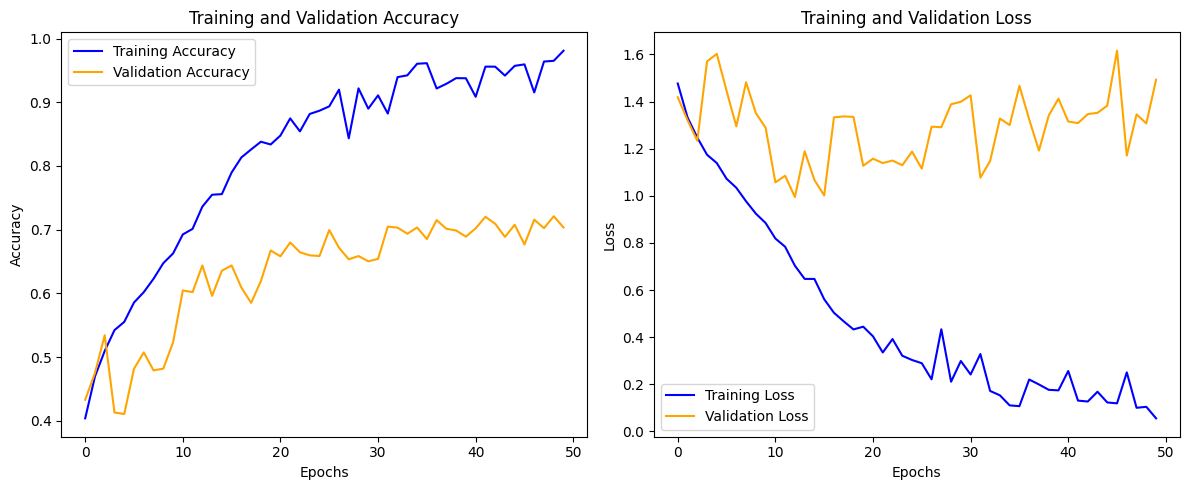

In [ ]:
import matplotlib.pyplot as plt

# 獲取訓練和測試的準確率與損失值
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 繪製準確率曲線
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 繪製損失曲線
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 顯示圖表
plt.tight_layout()
plt.show()


In [ ]:
from tensorflow.keras.models import load_model
import librosa
import numpy as np

# 參數設置
SAMPLE_RATE = 22050
FIXED_DURATION = 2.5
NUM_MFCC = 20

def preprocess_audio(file_path):
    """
    對音頻進行預處理，返回提取的 MFCC 特徵。

    參數：
    - file_path: 音頻文件的路徑。

    返回：
    - mfcc: 預處理後的 MFCC 特徵。
    """
    try:
        # 加載音頻文件
        audio, _ = librosa.load(file_path, sr=SAMPLE_RATE)

        # 預加重濾波器
        pre_emphasis = 0.97
        audio = np.append(audio[0], audio[1:] - pre_emphasis * audio[:-1])  # y(n) = x(n) - u * x(n-1)

        # 修正音頻長度
        audio = librosa.util.fix_length(audio, size=int(FIXED_DURATION * SAMPLE_RATE))

        # 提取 MFCC 特徵
        mfcc = librosa.feature.mfcc(
            y=audio,
            sr=SAMPLE_RATE,
            n_mfcc=NUM_MFCC,
            n_fft=2048,
            hop_length=512,
            win_length=2048,
            window='hamming'
        )
        return mfcc.T  # 轉置以匹配模型輸入格式
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# 定義情感標籤對應
EMOTION_LABELS = {0: 'ANG', 1: 'DIS', 2: 'FEA', 3: 'HAP', 4: 'NEU', 5: 'SAD'}

def predict_emotion(model, file_path):
    """
    使用加載的模型進行情感預測。

    參數：
    - model: 加載的 Keras 模型。
    - file_path: 音頻文件的路徑。

    返回：
    - prediction: 預測的情感標籤。
    """
    # 預處理音頻
    mfcc = preprocess_audio(file_path)
    if mfcc is None:
        return None

    # 增加批次維度
    mfcc = np.expand_dims(mfcc, axis=0)  # (1, 時間步長, 特徵數量)
    mfcc = np.expand_dims(mfcc, axis=-1)  # (1, 時間步長, 特徵數量, 1)

    # 進行預測
    predictions = model.predict(mfcc)
    predicted_label = np.argmax(predictions, axis=1)[0]
    return EMOTION_LABELS[predicted_label]


# 加載模型
model = load_model('emotion_recognition_model_C.keras')

# 測試音頻文件
audio_file = "/content/CREMA-D/AudioWAV/1001_DFA_ANG_XX.wav"  # 替換為您音頻文件的路徑

# 預測情感
emotion = predict_emotion(model, audio_file)

# 輸出結果
if emotion:
    print(f"The predicted emotion for the audio is: {emotion}")
else:
    print("Failed to process the audio file.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
The predicted emotion for the audio is: ANG
